In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down
import matplotlib.pyplot as plt

import warnings

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [2]:
resolution = '3h'
# resolution = 'daily'

In [3]:
tmpa_dir = os.path.join('..', 'data', 'tmpa_conus_data')
inputfile = os.path.join(tmpa_dir, f'data_tmpa_{resolution}.hdf5')
outfile = os.path.join(tmpa_dir, f'data_tmpa_{resolution}_cut.nc')

print(f'Input file : {inputfile}')
print(f'Output file: {outfile}')

Input file : ../data/tmpa_conus_data/data_tmpa_3h.hdf5
Output file: ../data/tmpa_conus_data/data_tmpa_3h_cut.nc


In [4]:
ncf = xr.open_dataset(inputfile, engine="h5netcdf",phony_dims='sort')

tmpalat = ncf['lat'][:].values
tmpalon = ncf['lon'][:].values
dates_int = ncf['dates'][:].values
dset = ncf['prcp'].values

if resolution == '3h':
    time_int = ncf['hours'][:].values
    dates = [datetime.strptime(str(integd)+str(inthour), '%Y%m%d%H') for integd, inthour in zip(dates_int, time_int)]
    description = "TMPA 3h"
elif resolution == 'daily':
    time_int = ncf['dates'][:].values
    dates = ncf['dates'][:].values
    description = "TMPA daily"
else:
    print('ERROR resolution dont found it')

del ncf

In [5]:
min_lon = -94
max_lon = -90
min_lat = 31
max_lat = 34

In [6]:
x = da.from_array(dset, chunks=(6, 6, 300))

xrs0 = xr.DataArray(x,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates}, dims=('lon', 'lat', 'time'))
xrs0 = xrs0.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

In [7]:
pre = np.array(xrs0.data)
pre = np.swapaxes(pre,0,2)
pre.shape

(2433, 12, 16)

In [8]:
PRE_xr = xr.Dataset(data_vars={"PRE": (("time", "lat", "lon"), pre)},
                    coords={'time': dates, 'lat': xrs0['lat'].values, 'lon': xrs0['lon'].values},
                    attrs=dict(description=description))
PRE_xr.PRE.attrs["units"] = "millimeter"
PRE_xr.lat.attrs["units"] = "degrees_north"
PRE_xr.lon.attrs["units"] = "degrees_east"

/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


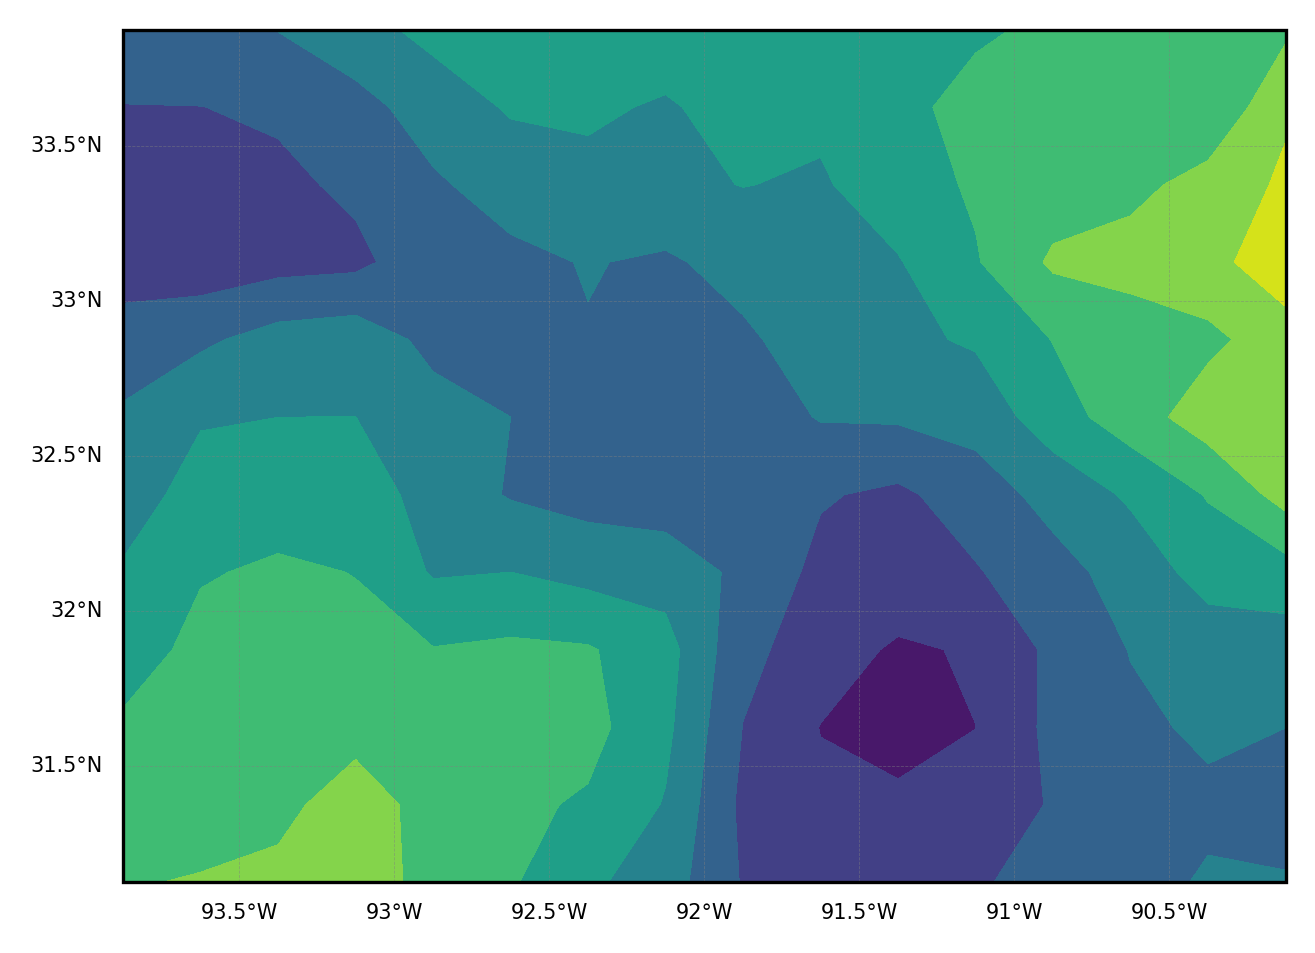

In [9]:
lon2d, lat2d = np.meshgrid(xrs0['lon'].values, xrs0['lat'].values)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,1)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
ax1.contourf(lon2d, lat2d, np.mean(pre,axis=0))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

In [11]:
print(f'Export PRE data to {outfile}')
PRE_xr.to_netcdf(outfile)

Export PRE data to ../data/tmpa_conus_data/data_tmpa_3h_cut.nc


In [12]:
PRE_xr

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 2433, lat: 12, lon: 16)
Coordinates:
  * time     (time) datetime64[ns] 19kB 2008-01-01 ... 2018-10-31T21:00:00
  * lat      (lat) float32 48B 31.12 31.38 31.62 31.88 ... 33.38 33.62 33.88
  * lon      (lon) float32 64B -93.88 -93.62 -93.38 ... -90.62 -90.38 -90.12
Data variables:
    PRE      (time, lat, lon) float32 2MB 0.0 0.5493 0.0 0.0 ... 0.0 6.641 2.782
Attributes:
    description:  TMPA 3h